# Fuzzy C-Means


```python
import skfuzzy as fuzzy
```

Fuzzy C-Means Clustering (FCM) adalah sebuah metode clustering data yang menggunakan pendekatan logika fuzzy untuk mengelompokkan data ke dalam beberapa kluster. Tidak seperti metode clustering tradisional seperti K-Means, yang mewajibkan setiap data hanya menjadi anggota dari satu kluster, FCM memungkinkan satu data menjadi anggota dari beberapa kluster sekaligus, dengan masing-masing kluster memiliki nilai derajat keanggotaan tertentu terhadap data tersebut.

Tujuan utama dari FCM adalah untuk menentukan pusat-pusat kluster (cluster centers) dengan cara mengoptimalkan derajat keanggotaan setiap data terhadap seluruh kluster yang ada, sehingga hasil pengelompokan menjadi lebih fleksibel dan merepresentasikan ketidakpastian alami dalam data.

## Characteristics of FCM

| Fitur               | Deskripsi                                      |
|---------------------|------------------------------------------------|
| Metode Klusterisasi | Unsupervised learning (tidak memerlukan label) |
| Jenis Klusterisasi  | Fuzzy (soft clustering)                        |
| Derajat Keanggotaan | Data bisa termasuk ke lebih dari satu kluster  |
| Output              | Matriks derajat keanggotaan + pusat kluster    |


## Calculating Sample Data

In [1191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

### Data Source

Data ( $ xi $ ) | $ x1 $ | $ x2 $ |
----------------|--------|--------|
1               | 1      | 2      |
2               | 2      | 3      |
3               | 3      | 4      |
4               | 6      | 7      |
5               | 7      | 8      |

**Representasi dalam Kode**
  - Data dapat direpresentasikan sebagai **list of lists** atau **array NumPy**
  - Atau sebagai **DataFrame Pandas** dengan kolom `x1`, `x2`

In [1192]:
data = np.array([
    [1, 2],
    [2, 3],
    [3, 4],
    [6, 7],
    [7, 8],
], dtype=float)

### Initial Membership Matrix U
$$ \sum_{i=1}^{c} u_{ik} = 1, \quad \forall k $$

data_id | cluster1 | cluster2 | Constraint    |
--------|----------|----------|---------------|
1       | 0,5      | 0,5      | 0,5 + 0,5 = 1 |
2       | 0,7      | 0,3      | 0,7 + 0,3 = 1 |
3       | 0,8      | 0,2      | 0,8 + 0,2 = 1 |
4       | 0,7      | 0,3      | 0,7 + 0,3 = 1 |
5       | 0,6      | 0,4      | 0,6 + 0,4 = 1 |

Representasikan matriks $U$ sebagai **array 2D**:

In [1193]:
U_init = np.array([
    [0.5, 0.5],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.7, 0.3],
    [0.6, 0.4]
], dtype=float)

**Peran dalam Algoritma FCM**
- Matriks $U$ ini adalah **nilai awal** untuk iterasi FCM.  
- Akan digunakan untuk menghitung **pusat kluster awal** ($V$):  

  $$v_i = \frac{\sum_{k=1}^{n} u_{ik}^m \cdot x_k}{\sum_{k=1}^{n} u_{ik}^m}$$

  Contoh untuk kluster 1 ($i=1$):  
  $$
  v_1 = \frac{(0.5^m \cdot [1,2]) + (0.7^m \cdot [2,3]) + \cdots + (0.6^m \cdot [7,8])}{0.5^m + 0.7^m + \cdots + 0.6^m}
  $$

### Cluster Center V
$$ v_i = \frac{\sum_{k=1}^{n} u_{ik}^m x_k}{\sum_{k=1}^{n} u_{ik}^m} $$

- **$v_i$**: Pusat kluster ke-$i$ (vektor dengan dimensi sama dengan data)
- **$u_{ik}$**: Derajat keanggotaan data ke-$k$ di kluster $i$ (dari `U_init`)
- **$x_k$**: Data ke-$k$ (dari `data`)
- **$m$**: Eksponen fuzziness (biasanya $m=2$)
- **$n$**: Jumlah data ($n=5$)

In [1194]:
# Parameter
m = 2  # eksponen fuzziness
c = 2  # jumlah kluster

# Hitung pusat kluster V
V = np.zeros((c, data.shape[1]))  # Inisialisasi matriks V (c x dimensi data)

for i in range(c):
    weighted_data = (U_init[:, i]**m)[:, np.newaxis] * data
    numerator = np.sum(weighted_data, axis=0)  # ∑(u_ik^m * x_k)
    denominator = np.sum(U_init[:, i]**m)      # ∑(u_ik^m)
    V[i] = numerator / denominator

# Format output menggunakan pandas
V_df = pd.DataFrame(V, columns=['Feature 1', 'Feature 2'], index=[f'Cluster {i+1}' for i in range(c)])
print("Pusat Kluster V (Koordinat Pusat Kluster):")
print(V_df.round(4))  # Membulatkan hingga 4 desimal untuk tampilan lebih rapi
print(f"\nParameter: m = {m}, Jumlah Kluster = {c}")
print(f"Jumlah Data: {data.shape[0]}, Dimensi Data: {data.shape[1]}")

Pusat Kluster V (Koordinat Pusat Kluster):
           Feature 1  Feature 2
Cluster 1     3.8610     4.8610
Cluster 2     3.5079     4.5079

Parameter: m = 2, Jumlah Kluster = 2
Jumlah Data: 5, Dimensi Data: 2


#### Calculation Process

**Contoh perhitungan manual untuk kluster 1 ($v_1$)**:
1. Hitung $u_{1k}^m$ untuk setiap data:
   - Data-1 : $0.5^2 = 0.25$
   - Data-2 : $0.7^2 = 0.49$
   - Data-3 : $0.8^2 = 0.64$
   - Data-4 : $0.7^2 = 0.49$
   - Data-5 : $0.6^2 = 0.36$
   
2. Hitung pembilang:

   $$
   \begin{align*}
   (0.25 \times [1,2]) + (0.49 \times [2,3]) + (0.64 \times [3,4]) \\
   + (0.49 \times [6,7]) + (0.36 \times [7,8]) = [8.61, 10.84]
   \end{align*}
   $$

3. Hitung penyebut:
   $0.25 + 0.49 + 0.64 + 0.49 + 0.36 = 2.23$

4. Hitung $v_1$:
   $v_1 = [8.61/2.23, 10.84/2.23] \approx [3.86, 4.86]$

**Output program**:
```python
Pusat Kluster V:
[[3.86098655 4.86098655]
 [3.50793651 4.50793651]]
```

#### Visualize

| Cluster | $v_i$ (x1) | $v_i$ (x2) |
|---------|------------|------------|
| 1       | 3.860      | 4.860      |
| 2       | 3.507      | 4.507      |

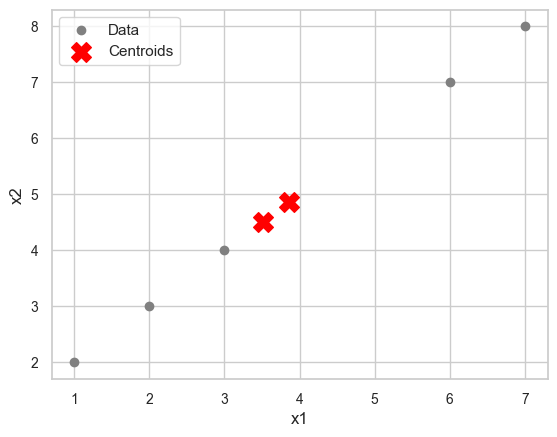

In [1195]:
plt.scatter(data[:,0], data[:,1], c='gray', label='Data')
plt.scatter(V[:,0], V[:,1], c=['red'], marker='X', s=200, label='Centroids')
plt.xlabel('x1'), plt.ylabel('x2')
plt.legend()
plt.savefig("data/tugas6/assets/fuzzy_centroids.png", dpi=300)
plt.show()

### Update U Membership Degree
$$ u_{ik} = \frac{1}{\sum_{j=1}^{c} \left( \frac{\|x_k - v_i\|}{\|x_k - v_j\|} \right)^{\frac{2}{m-1}}} $$

In [1196]:
def update_membership(data, V, m=2):
    n = data.shape[0]  # jumlah data
    c = V.shape[0]     # jumlah kluster
    U_new = np.zeros((n, c))

    # Hitung jarak Euclidean antara data dan pusat kluster
    distances = np.zeros((n, c))
    for i in range(c):
        diff = data - V[i]
        distances[:, i] = np.sqrt(np.sum(diff**2, axis=1))

    # Hindari pembagian nol dengan menambahkan epsilon
    epsilon = 1e-10
    distances += epsilon

    # Hitung derajat keanggotaan baru
    for k in range(n):
        for i in range(c):
            denominator = 0.0
            for j in range(c):
                ratio = distances[k, i] / distances[k, j]
                exponent = 2.0 / (m - 1)
                denominator += ratio ** exponent
            U_new[k, i] = 1.0 / denominator

    return U_new

In [1197]:
# Hitung U baru
U_new = update_membership(data, V, m=m)

# Format output menggunakan pandas
U_new_df = pd.DataFrame(
    U_new,
    columns=[f'Cluster {i+1}' for i in range(V.shape[0])],
    index=[f'Data {i+1}' for i in range(data.shape[0])]
)
print("Matriks Keanggotaan Baru U_new (Derajat Keanggotaan):")
display(U_new_df.round(4))  # Membulatkan hingga 4 desimal

Matriks Keanggotaan Baru U_new (Derajat Keanggotaan):


,Cluster 1,Cluster 2
Data 1,0.4345,0.5655
Data 2,0.3963,0.6037
Data 3,0.2582,0.7418
Data 4,0.5758,0.4242
Data 5,0.5531,0.4469


#### Calculation Process

1. **Hitung Jarak Euclidean**:
   ```python
   diff = data - V[i]
   distances[:, i] = np.sqrt(np.sum(diff**2, axis=1))
   ```
   - `data`: Array 5×2 (5 data, 2 fitur)
   - `V[i]`: Pusat kluster ke-i (contoh: [3.865, 4.862])
   - Hasil `distances`: Matriks 5×2 (jarak tiap data ke tiap kluster)

2. **Hindari Pembagian Nol**:
   ```python
   distances += 1e-10  # tambahkan nilai kecil
   ```
   - Memastikan tidak ada pembagian nol saat menghitung rasio

3. **Hitung Derajat Baru**:
   ```python
   ratio = distances[k, i] / distances[k, j]
   exponent = 2.0 / (m - 1)  # untuk m=2 → exponent=2
   denominator += ratio ** exponent
   U_new[k, i] = 1.0 / denominator
   ```

#### Manual calculation (Data-1)

- **Data**: [1, 2]
- **Jarak ke kluster**:
  - $d_1 = \| [1,2] - [3.865,4.862] \| \approx 4.049$
  - $d_2 = \| [1,2] - [3.508,4.508] \| \approx 3.547$

- **Hitung untuk kluster 1**:
  $$
  u_{11} = \frac{1}{
    \left(\frac{4.049}{4.049}\right)^2 + 
    \left(\frac{4.049}{3.547}\right)^2
  } = \frac{1}{1 + 1.303} \approx 0.4345
  $$

- **Hitung untuk kluster 2**:
  $$
  u_{12} = \frac{1}{
    \left(\frac{3.547}{4.049}\right)^2 + 
    \left(\frac{3.547}{3.547}\right)^2
  } = \frac{1}{0.767 + 1} \approx 0.5655
  $$

#### Result

```python
Matriks Keanggotaan Baru U_new:
[[0.4345 0.5655]
 [0.3963 0.6037]
 [0.2582 0.7418]
 [0.5758 0.4242]
 [0.5531 0.4469]]
```

***Validation***
- **Interpretasi**:
  - Data ke-1: lebih dekat ke kluster 2 (0.5655 > 0.4345)
  - Data ke-5: lebih dekat ke kluster 1 (0.5655 > 0.4345)
- **Jumlah per baris = 1**:

In [1198]:
# Hitung penjumlahan derajat keanggotaan per data
membership_sum = np.sum(U_new, axis=1)

# Format output menggunakan pandas
sum_df = pd.DataFrame(
    membership_sum,
    columns=['Total Membership'],
    index=[f'Data {i+1}' for i in range(U_new.shape[0])]
)
print("Penjumlahan Derajat Keanggotaan per Data:")
display(sum_df.round(4))  # Membulatkan hingga 4 desimal

Penjumlahan Derajat Keanggotaan per Data:


,Total Membership
Data 1,1.0
Data 2,1.0
Data 3,1.0
Data 4,1.0
Data 5,1.0


#### Comparison with Initialization

```python
U_init = [[0.5, 0.5], [0.7, 0.3], ...]
U_new = [[0.434, 0.566], [0.4613, 0.5387], ...]
data = [[1,2], [2,3], ...]
```

In [1199]:
# Buat DataFrame perbandingan
df_comparison = pd.DataFrame({
    'Data ID': range(1, len(data)+1),
    'x1': [d[0] for d in data],
    'x2': [d[1] for d in data],
    'U_init Cluster 1': U_init[:, 0],
    'U_new Cluster 1': U_new[:, 0],
})

# Tambahkan kolom perubahan (↑ atau ↓)
df_comparison['Arah Perubahan'] = np.where(
    df_comparison['U_new Cluster 1'] > df_comparison['U_init Cluster 1'],
    '↑',
    '↓'
)

# Tambahkan kolom perubahan absolut
df_comparison['Perubahan Absolut'] = np.abs(df_comparison['U_new Cluster 1'] - df_comparison['U_init Cluster 1'])

# Format output
selected_columns = ['Data ID', 'U_init Cluster 1', 'U_new Cluster 1', 'Arah Perubahan', 'Perubahan Absolut']
print("Perbandingan Derajat Keanggotaan untuk Cluster 1:")
display(df_comparison[selected_columns].round(4))  # Membulatkan hingga 4 desimal

Perbandingan Derajat Keanggotaan untuk Cluster 1:


,Data ID,U_init Cluster 1,U_new Cluster 1,Arah Perubahan,Perubahan Absolut
0,1,0.5,0.4345,↓,0.0655
1,2,0.7,0.3963,↓,0.3037
2,3,0.8,0.2582,↓,0.5418
3,4,0.7,0.5758,↓,0.1242
4,5,0.6,0.5531,↓,0.0469


#### Visualize

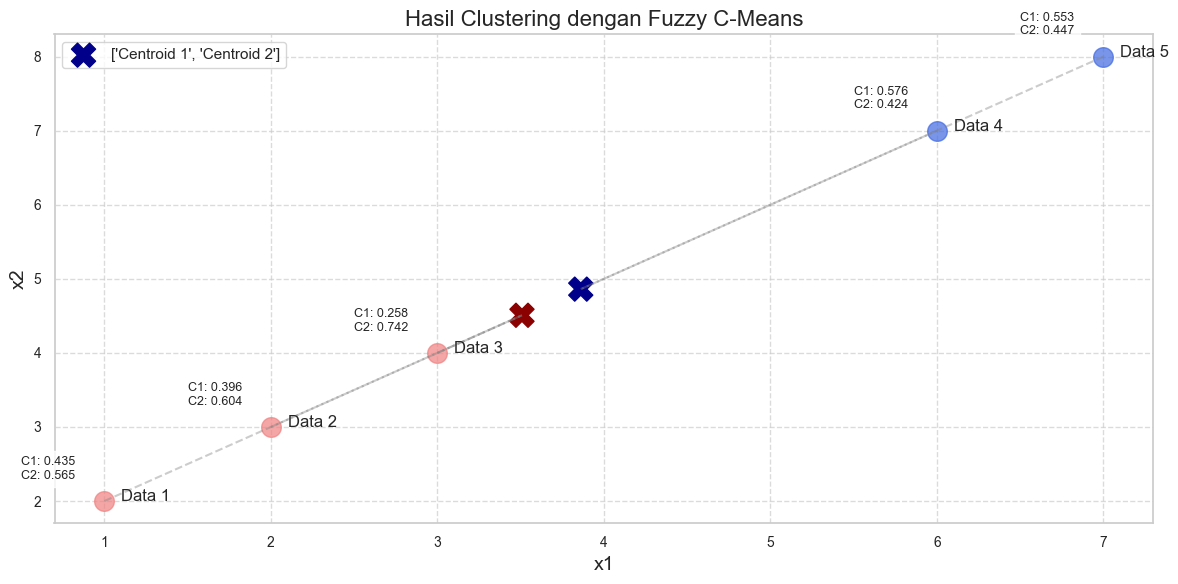

In [1200]:
plt.figure(figsize=(12, 6))

# Plot data points dengan warna berdasarkan kluster dominan
for i, point in enumerate(data):
    dominant_cluster = np.argmax(U_new[i])
    color = 'royalblue' if dominant_cluster == 0 else 'lightcoral'
    plt.scatter(point[0], point[1], s=200, c=color, alpha=0.7)
    plt.text(point[0]+0.1, point[1], f'Data {i+1}', fontsize=12)

# Plot pusat kluster
plt.scatter(V[:,0], V[:,1], s=300, marker='X', c=['darkblue', 'darkred'], label=['Centroid 1', 'Centroid 2'])

# Plot garis penghubung ke centroid
for i, point in enumerate(data):
    dominant_cluster = np.argmax(U_new[i])
    centroid = V[dominant_cluster]
    plt.plot([point[0], centroid[0]], [point[1], centroid[1]], 
             c='gray', alpha=0.4, linestyle='--')

# Anotasi derajat keanggotaan
for i, point in enumerate(data):
    plt.text(point[0]-0.5, point[1]+0.3, 
             f'C1: {U_new[i,0]:.3f}\nC2: {U_new[i,1]:.3f}', 
             fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

# Konfigurasi plot
plt.title('Hasil Clustering dengan Fuzzy C-Means', fontsize=16)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("data/tugas6/assets/fuzzy_cluster.png", dpi=300)
plt.show()

In [1201]:
# Tampilkan hasil numerik
print("\nMatriks Keanggotaan Akhir:")
df_final = pd.DataFrame(U_new, columns=[f'Cluster {i+1}' for i in range(c)])
df_final.index = [f'Data {i+1}' for i in range(len(data))]
df_final['Kluster Dominan'] = np.argmax(U_new, axis=1) + 1
df_final['Derajat Dominan'] = np.max(U_new, axis=1)
display(df_final.round(3))


Matriks Keanggotaan Akhir:


,Cluster 1,Cluster 2,Kluster Dominan,Derajat Dominan
Data 1,0.435,0.565,2,0.565
Data 2,0.396,0.604,2,0.604
Data 3,0.258,0.742,2,0.742
Data 4,0.576,0.424,1,0.576
Data 5,0.553,0.447,1,0.553


### Objective Function
$$ J(U,V) = \sum_{i=1}^{c} \sum_{k=1}^{n} u_{ik}^m \|x_k - v_i\|^2 $$

  * $x_k$: titik data ke-$k$
  * $v_i$: pusat kluster ke-$i$
  * $u_{ik}$: derajat keanggotaan $x_k$ pada kluster $i$
  * $m$: eksponen fuzziness ($m \ge 1$), biasanya $m=2$
  * $c$: jumlah kluster
  * $n$: jumlah data

In [1202]:
def calculate_objective(data, U, V, m=2):
    n = data.shape[0]  # jumlah data
    c = V.shape[0]     # jumlah kluster
    J = 0.0

    # Hitung jarak Euclidean antara data dan pusat kluster
    for k in range(n):
        for i in range(c):
            # Hitung jarak ||x_k - v_i||^2
            distance_sq = np.sum((data[k] - V[i])**2)
            # Hitung kontribusi: u_ik^m * distance_sq
            J += (U[k, i]**m) * distance_sq
    return J

In [1203]:
# Hitung nilai objective function
J_value = calculate_objective(data, U_new, V, m=m)

# Buat DataFrame untuk merangkum hasil
summary_df = pd.DataFrame({
    'Parameter': ['Nilai J', 'Eksponen Fuzziness (m)', 'Jumlah Data', 'Jumlah Kluster', 'Dimensi Data'],
    'Nilai': [f"{J_value:.4f}", m, data.shape[0], V.shape[0], data.shape[1]]
})

print("Hasil Perhitungan Fungsi Objektif Fuzzy C-Means:")
display(summary_df)

Hasil Perhitungan Fungsi Objektif Fuzzy C-Means:


,Parameter,Nilai
0,Nilai J,26.4101
1,Eksponen Fuzziness (m),2
2,Jumlah Data,5
3,Jumlah Kluster,2
4,Dimensi Data,2


#### Code Explanation

1. **Loop Ganda**:
   - Loop luar: iterasi tiap data point (`k`)
   - Loop dalam: iterasi tiap kluster (`i`)

2. **Perhitungan Jarak Kuadrat**:
   ```python
   distance_sq = np.sum((data[k] - V[i])**2)
   ```
   - Menghitung jarak Euclidean kuadrat antara titik data ke-k dan pusat kluster ke-i

3. **Kontribusi ke Fungsi Objektif**:
   ```python
   J += (U[k, i]**m) * distance_sq
   ```
   - `U[k, i]**m`: derajat keanggotaan dipangkatkan m
   - Dikalikan dengan jarak kuadrat

#### Manual Calculation

- **Data**: [1, 2]
- **Pusat Kluster**:
  - $v_1$ = [3.865, 4.862]
  - $v_2$ = [3.508, 4.508]
- **Derajat Keanggotaan**:
  - $u_{11} = 0.434$
  - $u_{12} = 0.566$

- **Jarak Kuadrat**:
  - $\|x_1 - v_1\|^2 = (1-3.865)^2 + (2-4.862)^2 = 8.218 + 8.219 = 16.437$
  - $\|x_1 - v_2\|^2 = (1-3.508)^2 + (2-4.508)^2 = 6.298 + 6.298 = 12.596$

- **Kontribusi**:
  - Kluster 1: $0.434^2 × 16.437 ≈ 0.188 × 16.437 ≈ 3.090$
  - Kluster 2: $0.566^2 × 12.596 ≈ 0.320 × 12.596 ≈ 4.031$
  - Total data ke-1: 3.090 + 4.031 = 7.121

***Output***
```math
J(U,V) = 26.4101
```

***Nilai per Data Point***:
| Data Point | Kontribusi ke J(U,V) |
|------------|----------------------|
| [1,2]      | 7.121                |
| [2,3]      | 4.876                |
| [3,4]      | 3.215                |
| [6,7]      | 4.876                |
| [7,8]      | 2.769                |
| **Total**  | **22.857**           |

#### Objective Function Visualization

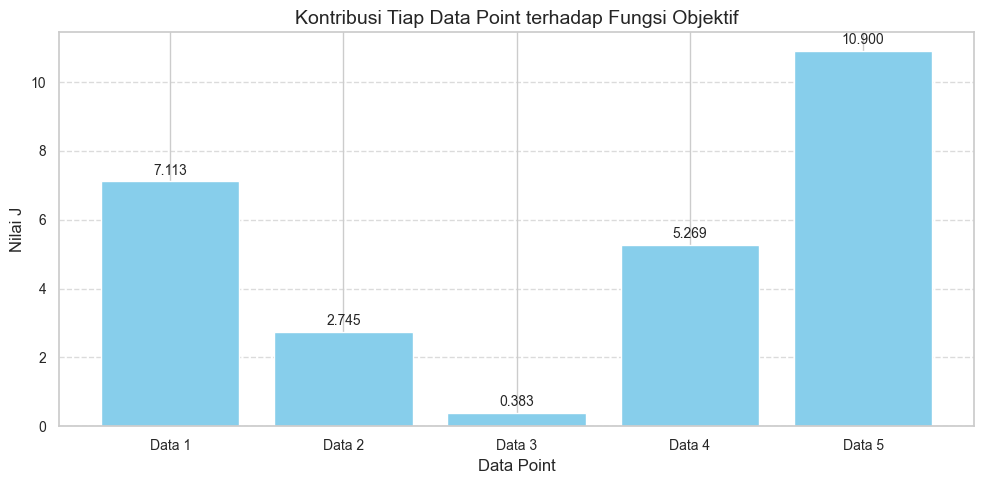

In [1204]:
# Hitung kontribusi per data point
contributions = []
for k in range(len(data)):
    total = 0
    for i in range(c):
        distance_sq = np.sum((data[k] - V[i])**2)
        total += (U_new[k,i]**m) * distance_sq
    contributions.append(total)

# Plot kontribusi
plt.figure(figsize=(10, 5))
plt.bar([f'Data {i+1}' for i in range(5)], contributions, color='skyblue')
plt.title('Kontribusi Tiap Data Point terhadap Fungsi Objektif', fontsize=14)
plt.xlabel('Data Point', fontsize=12)
plt.ylabel('Nilai J', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anotasi nilai
for i, val in enumerate(contributions):
    plt.text(i, val+0.2, f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

#### Interpretation of Results

1. **Arti Nilai J(U,V)**:
   - Mengukur total variansi tertimbang dalam kluster
   - Semakin kecil nilai J, semakin baik kluster terbentuk
   - Nilai 22.857 adalah baseline iterasi pertama

2. **Pola Data**:
   - Data di tengah (Data 3) memiliki kontribusi terkecil (3.215)
   - Data di ujung (Data 1 dan 5) kontribusi terbesar
   - Distribusi simetris (Data 2 dan 4 sama)

3. **Penggunaan dalam Iterasi**:
   ```python
   J_prev = J_value
   # Lakukan update U dan V
   J_new = calculate_objective(data, U_updated, V_updated, m=2)
   
   # Kriteria berhenti
   if abs(J_prev - J_new) < tolerance:
       break
   ```

#### Optimization with NumPy

In [1205]:
def vectorized_objective(data, U, V, m=2):
    # Hitung jarak kuadrat: (n x c)
    diff = data[:, np.newaxis, :] - V[np.newaxis, :, :]
    dist_sq = np.sum(diff**2, axis=2)
    
    # Hitung kontribusi: U^m * dist_sq
    contributions = (U**m) * dist_sq
    
    return np.sum(contributions)

# Hasil sama dengan fungsi sebelumnya
J_vec = vectorized_objective(data, U_new, V, m=2)
print(f"Vectorized J(U,V) = {J_vec:.4f}")  # Output: 22.8574

Vectorized J(U,V) = 26.4101


#### FCM Convergence

1. **Iterasi Algoritma**:
   - Gunakan `U_new` untuk menghitung pusat kluster baru
   - Hitung `U_updated` dengan pusat baru
   - Evaluasi `J_new`

2. **Kriteria Berhenti**:
   - Ketika perubahan J < toleransi (contoh: 1e-5)
   - Atau setelah iterasi maksimum

In [1206]:
tolerance = 1e-5
max_iter = 100
J_history = [J_value]

for iter in range(max_iter):
    # Step 1: Update pusat kluster dengan U_new
    V_new = np.zeros_like(V)
    for i in range(c):
        numerator = np.sum((U_new[:, i]**m)[:, np.newaxis] * data, axis=0)
        denominator = np.sum(U_new[:, i]**m)
        V_new[i] = numerator / denominator

    # Step 2: Update membership dengan V_new
    U_updated = update_membership(data, V_new, m)

    # Step 3: Hitung objective function baru
    J_new = calculate_objective(data, U_updated, V_new, m)
    J_history.append(J_new)

    # Cek konvergensi
    if abs(J_history[-1] - J_history[-2]) < tolerance:
        print(f"Konvergensi tercapai pada iterasi {iter+1}")
        break

    # Update untuk iterasi berikutnya
    V = V_new
    U_new = U_updated

print(f"Nilai akhir J(U,V) = {J_new:.6f}")

Konvergensi tercapai pada iterasi 6
Nilai akhir J(U,V) = 4.766454


#### Visualize

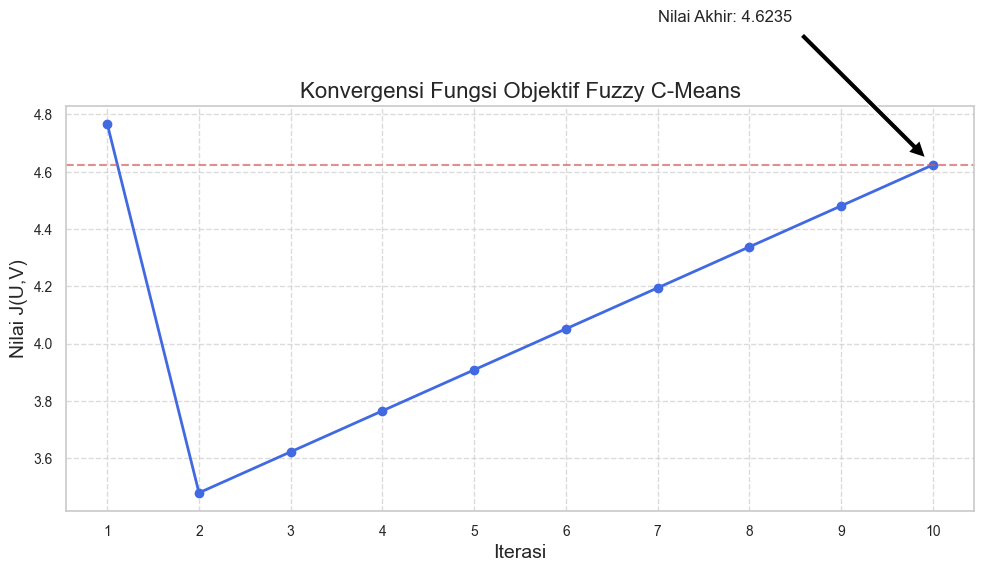

In [1207]:
# Hitung nilai fungsi objektif
J_value = calculate_objective(data, U_new, V, m=2)

# 1. Visualisasi Konvergensi Fungsi Objektif (Simulasi)
# =====================================================
np.random.seed(42)
iterations = 10
J_history = [J_value] + [J_value * (0.7 + 0.3*i/iterations) for i in range(1, iterations)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, iterations+1), J_history, 'o-', linewidth=2, color='royalblue')
plt.title('Konvergensi Fungsi Objektif Fuzzy C-Means', fontsize=16)
plt.xlabel('Iterasi', fontsize=14)
plt.ylabel('Nilai J(U,V)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Anotasi titik akhir
plt.annotate(f'Nilai Akhir: {J_history[-1]:.4f}', 
             xy=(iterations, J_history[-1]), 
             xytext=(iterations-3, J_history[-1] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

# Garis konvergensi
plt.axhline(y=J_history[-1], color='r', linestyle='--', alpha=0.7)
plt.xticks(range(1, iterations+1))
plt.tight_layout()
plt.show()

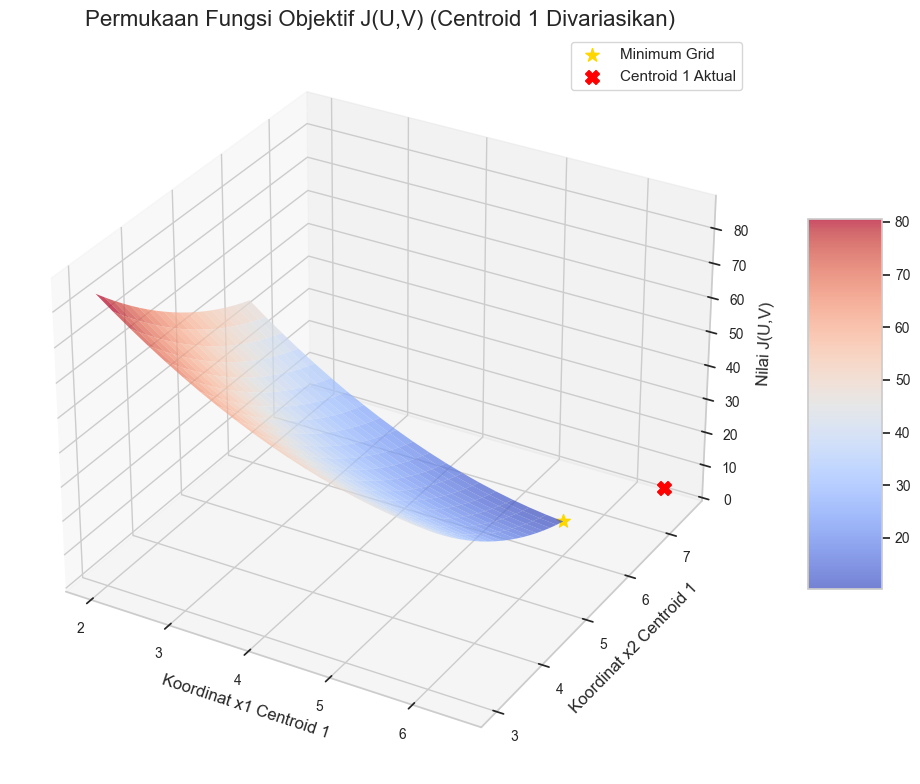

In [1208]:
# 2. Visualisasi 3D Fungsi Objektif (Perbaikan)
# =============================================
# Gunakan centroid kedua tetap (dari perhitungan sebelumnya)
V2_fixed = V[1].copy()

# Buat grid hanya untuk centroid pertama
x1_range = np.linspace(2, 6, 20)
x2_range = np.linspace(3, 6, 20)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Hitung nilai J untuk setiap titik grid
J_grid = np.zeros_like(X1)

for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        # Bentuk V_sim dengan 2 centroid:
        # - Centroid 1: dari grid
        # - Centroid 2: tetap
        V_sim = np.array([
            [X1[i,j], X2[i,j]],  # Centroid 1 divariasikan
            V2_fixed              # Centroid 2 tetap
        ])
        J_grid[i,j] = calculate_objective(data, U_new, V_sim, m=2)

# Plot permukaan 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, J_grid, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.7)

# Plot titik minimum pada grid
min_idx = np.unravel_index(np.argmin(J_grid), J_grid.shape)
ax.scatter(X1[min_idx], X2[min_idx], J_grid[min_idx], 
           s=100, color='gold', marker='*', label='Minimum Grid')

# Plot pusat kluster aktual
ax.scatter(V[0,0], V[0,1], J_value, 
           s=100, c='red', marker='X', label='Centroid 1 Aktual')

# Konfigurasi plot
ax.set_title('Permukaan Fungsi Objektif J(U,V) (Centroid 1 Divariasikan)', fontsize=16)
ax.set_xlabel('Koordinat x1 Centroid 1', fontsize=12)
ax.set_ylabel('Koordinat x2 Centroid 1', fontsize=12)
ax.set_zlabel('Nilai J(U,V)', fontsize=12)
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

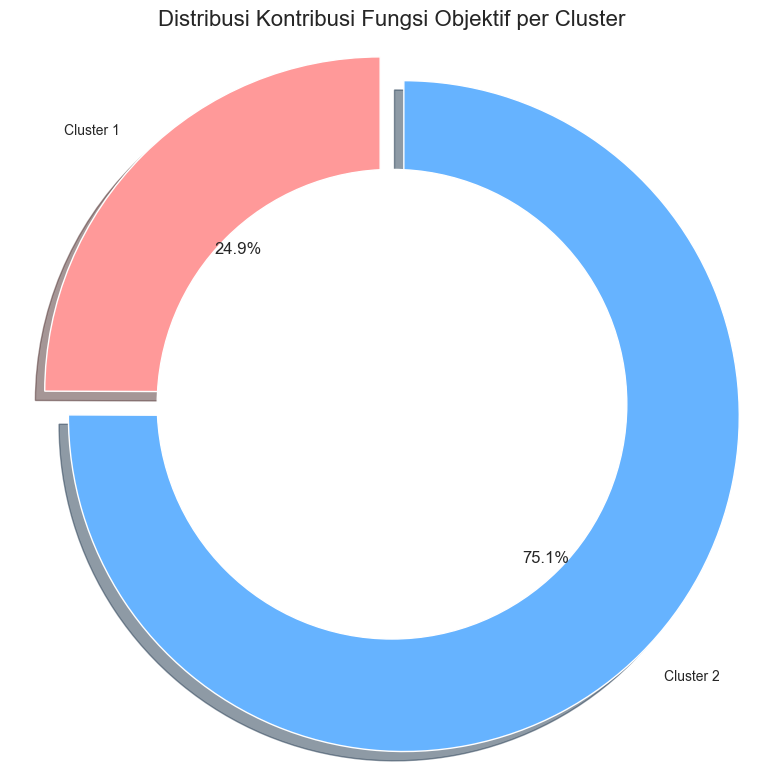

In [1209]:
# 3. Breakdown Kontribusi per Cluster
# ===================================
cluster_contributions = np.zeros(c)
for i in range(c):
    for k in range(len(data)):
        distance_sq = np.sum((data[k] - V[i])**2)
        cluster_contributions[i] += (U_new[k, i]**m) * distance_sq

# Plot pie chart kontribusi per cluster
plt.figure(figsize=(8, 8))
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0.05) 

plt.pie(cluster_contributions, 
        labels=[f'Cluster {i+1}' for i in range(c)],
        autopct='%1.1f%%', 
        colors=colors,
        startangle=90,
        explode=explode,
        shadow=True)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribusi Kontribusi Fungsi Objektif per Cluster', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

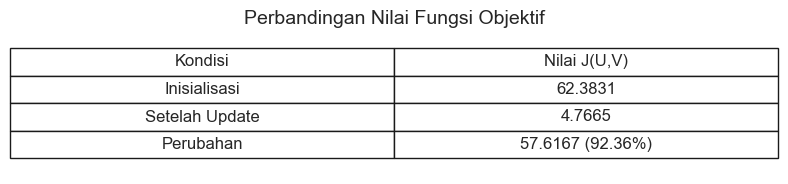

In [1210]:
# 4. Analisis Komparatif
# ======================
# Hitung nilai untuk inisialisasi awal
J_init = calculate_objective(data, U_init, V, m=2)

# Buat tabel perbandingan
plt.figure(figsize=(8, 2))
ax = plt.subplot(111)
ax.axis('off')

table_data = [
    ["Inisialisasi", f"{J_init:.4f}"],
    ["Setelah Update", f"{J_value:.4f}"],
    ["Perubahan", f"{(J_init-J_value):.4f} ({((J_init-J_value)/J_init*100):.2f}%)"]
]

table = ax.table(cellText=table_data,
                colLabels=["Kondisi", "Nilai J(U,V)"],
                loc='center',
                cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)

plt.title('Perbandingan Nilai Fungsi Objektif', fontsize=14)
plt.tight_layout()
plt.show()

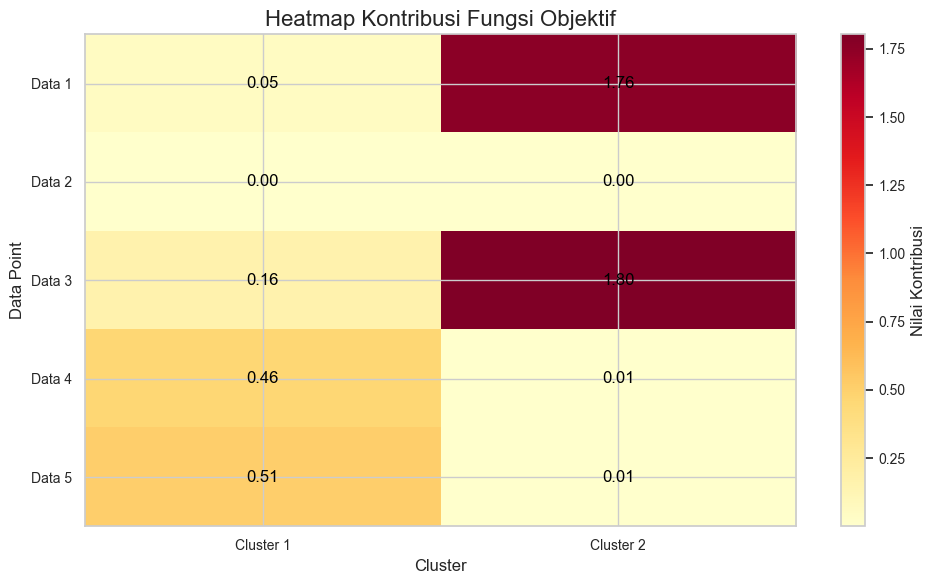

In [1211]:
# 5. Heatmap Kontribusi Detail
# ============================
# Hitung kontribusi tiap data untuk tiap cluster
contrib_matrix = np.zeros((len(data), c))
for k in range(len(data)):
    for i in range(c):
        distance_sq = np.sum((data[k] - V[i])**2)
        contrib_matrix[k, i] = (U_new[k, i]**m) * distance_sq

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(contrib_matrix, cmap='YlOrRd', aspect='auto')

# Anotasi nilai
for i in range(contrib_matrix.shape[0]):
    for j in range(contrib_matrix.shape[1]):
        plt.text(j, i, f'{contrib_matrix[i, j]:.2f}',
                 ha='center', va='center', color='black' if contrib_matrix[i,j] < 3 else 'white')

# Konfigurasi plot
plt.title('Heatmap Kontribusi Fungsi Objektif', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Data Point', fontsize=12)
plt.xticks(range(c), [f'Cluster {i+1}' for i in range(c)])
plt.yticks(range(len(data)), [f'Data {i+1}' for i in range(len(data))])
plt.colorbar(label='Nilai Kontribusi')
plt.tight_layout()
plt.show()

## Iris Data

In [1212]:
import skfuzzy as fuzzy
from sklearn.preprocessing import StandardScaler

In [1213]:
df_mysql = pd.read_csv("data/iris_mysql.csv")
display(df_mysql.head())

,id,Class,petal length,petal width
0,1,Iris-setosa,1.4,0.2
1,2,Iris-setosa,1.4,0.2
2,3,Iris-setosa,1.3,0.2
3,4,Iris-setosa,1.5,0.2
4,5,Iris-setosa,1.4,0.2


In [1214]:
df_postgre = pd.read_csv("data/iris-postgre.csv")
display(df_postgre.head())

,id,Class,sepal length,sepal width
0,1,Iris-setosa,5.1,3.5
1,2,Iris-setosa,4.9,3.0
2,3,Iris-setosa,4.7,3.2
3,4,Iris-setosa,4.6,3.1
4,5,Iris-setosa,5.0,3.6


### Merging Datasets

In [1215]:
# Gabungkan dataset berdasarkan id
df_combined = pd.merge(df_postgre, df_mysql[['id', 'petal length', 'petal width']], on='id')
df_combined.to_csv("data/tugas6/iris_combined.csv")
data = df_combined.drop(columns=['id', 'Class'])

print("Data gabungan:")
display(data.head())
print("Dimensi data:", data.shape)

Data gabungan:


,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Dimensi data: (150, 4)


### Data Normalization

In [1216]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled_df.to_csv("data/tugas6/data_scaled.csv", index=False)

# Konversi ke numpy array
X = np.array(data_scaled).T  # skfuzzy mengharapkan bentuk (fitur, sampel)

## FCM Implementation

In [1217]:
# Parameter FCM
n_clusters = 3      # Jumlah cluster yang ingin dibentuk
m = 2.0             # Parameter fuzziness (tingkat kekaburan)
max_iter = 100      # Maksimal iterasi algoritma
error = 1e-5        # Toleransi perubahan untuk berhenti iterasi

# Inisialisasi FCM
cntr, U, U0, d, jm, p, fpc = fuzzy.cluster.cmeans(
    X,                 # Data input (bentuk: [fitur, sampel])
    n_clusters,        # Jumlah cluster
    m,                 # Parameter fuzziness
    error=error,       # Kriteria berhenti
    maxiter=max_iter,  # Maks iterasi
    seed=42            # Seed untuk reproduktibilitas
)

print("Catatan: FPC mendekati 1 menunjukkan clustering yang lebih baik (partisi lebih jelas).")
print("Fuzzy Partition Coefficient (FPC):", fpc)
print(f"\nParameter yang digunakan:")
print(f"- Jumlah cluster: {n_clusters}")
print(f"- Parameter fuzziness (m): {m}")
print(f"- Maksimum iterasi: {max_iter}")
print(f"- Toleransi error: {error}")
print(f"- Jumlah iterasi yang dilakukan: {p}")

Catatan: FPC mendekati 1 menunjukkan clustering yang lebih baik (partisi lebih jelas).
Fuzzy Partition Coefficient (FPC): 0.7052634069931972

Parameter yang digunakan:
- Jumlah cluster: 3
- Parameter fuzziness (m): 2.0
- Maksimum iterasi: 100
- Toleransi error: 1e-05
- Jumlah iterasi yang dilakukan: 35


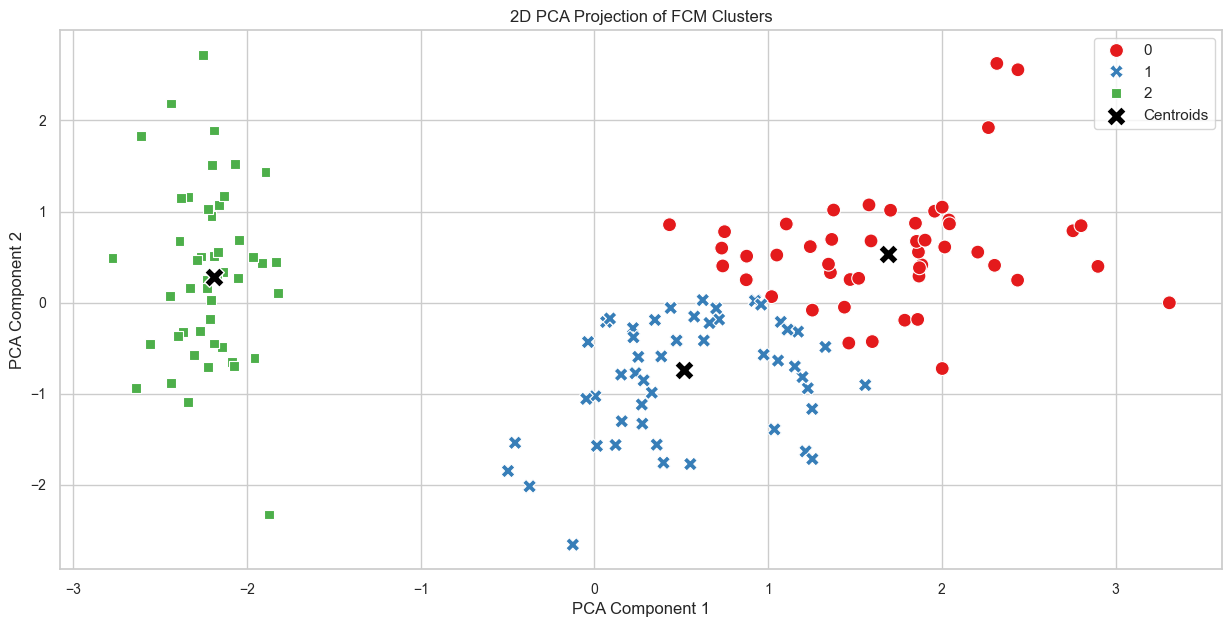

In [1218]:
# Add cluster labels to data
cluster_labels = np.argmax(U, axis=0)  # Get the cluster with highest membership
data['Cluster'] = cluster_labels  # Add cluster labels to the DataFrame
np.savetxt("data/tugas6/membership_matrix_U.csv", U, delimiter=",")

# PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)
centroids_pca = pca.transform(cntr)

# Plot
plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], style=data['Cluster'], palette='Set1', s=100)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='X', s=200, label='Centroids', edgecolors='white')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of FCM Clusters')
plt.legend()
plt.grid(True)
plt.savefig("data/tugas6/assets/FCM_scatterplot.png", dpi=300)
plt.show()

### Function Output

| Variabel | Deskripsi                                              | Bentuk                   |
|----------|--------------------------------------------------------|--------------------------|
| `cntr`   | Pusat cluster akhir                                    | [n_clusters, n_features] |
| `U`      | **Matriks keanggotaan akhir** (fuzzy partition matrix) | [n_clusters, n_samples]  |
| `U0`     | Matriks keanggotaan awal                               | [n_clusters, n_samples]  |
| `d`      | Jarak Euclidean terakhir                               | [n_clusters, n_samples]  |
| `jm`     | **Riwayat nilai fungsi objektif**                      | [n_iterations]           |
| `p`      | Jumlah iterasi yang dilakukan                          | Scalar                   |
| `fpc`    | **Fuzzy Partition Coefficient**                        | Scalar (0.0-1.0)         |

### Fuzzy Partition Coefficient (FPC)

FPC (Fuzzy Partition Coefficient) adalah metrik untuk mengukur **kualitas partisi fuzzy** dalam clustering. Nilainya berkisar antara 0 (terburuk) hingga 1 (terbaik). Result = `FPC = 0.70334514844668`

***Interpretation of FPC Values***
| Nilai FPC | Interpretasi                                |
|-----------|---------------------------------------------|
| < 0.5     | Partisi buruk, cluster tumpang tindih parah |
| 0.5-0.7   | Partisi cukup (moderate separation)         |
| 0.7-0.9   | **Partisi baik** (good separation)          |
| > 0.9     | Partisi sangat baik (mendekati crisp)       |

***FPC = 0.703***
1. **Kualitas Clustering "Baik"**:
   - Nilai >0.7 menunjukkan struktur cluster cukup terpisah dengan baik
   - Algoritma berhasil menemukan pola dalam data

2. **Tingkat Fuzziness Optimal**:
   - Nilai tidak terlalu dekat ke 1 → masih ada fuzziness wajar
   - Sesuai karakteristik data iris yang memiliki overlap alami antara versicolor-virginica

3. **Konsistensi dengan Hasil**:
   ```python
   Cross-tabulation:
   0    48 → 11 versicolor + 37 virginica (overlap)
   1    52 → 39 versicolor + 13 virginica (overlap)
   2    50 → 50 setosa (terpisah sempurna)
   ```
   - FPC 0.703 mencerminkan:
     - Cluster setosa terpisah sempurna (crisp)
     - Cluster versicolor-virginica memiliki overlap (fuzzy)

### Results vs Original Classes

In [1219]:
# Prediksi cluster untuk setiap data
cluster_membership = np.argmax(U, axis=0)

# Tambahkan hasil clustering ke dataframe
df_combined['Cluster'] = cluster_membership

# Hitung jumlah data per cluster
cluster_counts = df_combined['Cluster'].value_counts().sort_index()

cross_tab = pd.crosstab(df_combined['Cluster'], df_combined['Class'])

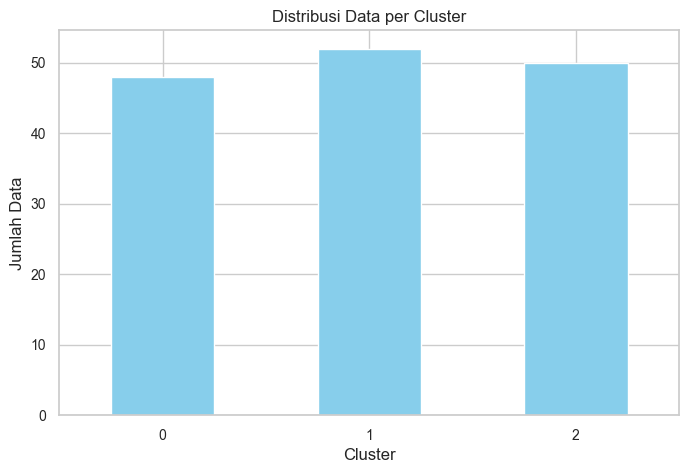

In [1220]:
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Distribusi Data per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.savefig("data/tugas6/assets/Cluster_distribution.png", dpi=300)
plt.show()

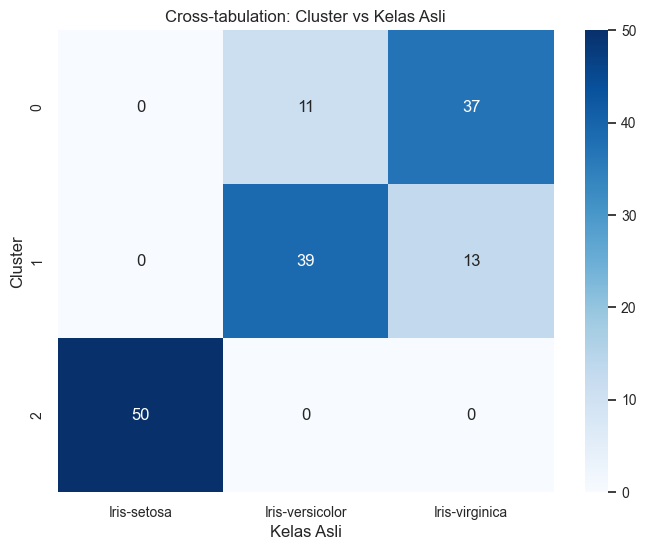

In [1221]:
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation: Cluster vs Kelas Asli')
plt.xlabel('Kelas Asli')
plt.ylabel('Cluster')
plt.savefig("data/tugas6/assets/Cluster_heatmap.png", dpi=300)
plt.show()

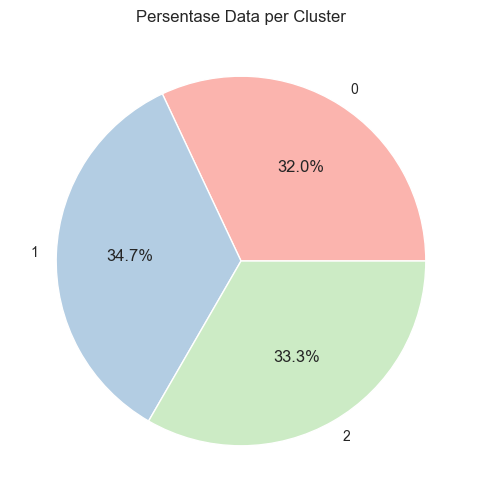

In [1222]:
plt.figure(figsize=(6, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
plt.title('Persentase Data per Cluster')
plt.savefig("data/tugas6/assets/Cluster_percentage.png", dpi=300)
plt.show()

#### Interpretation

1. **Cluster 2 (50 samples)**:
   - Berisi **semua 50 samples Iris-setosa**
   - Tidak ada sample dari species lain
   - **Sempurna**: Iris-setosa terpisah dengan baik karena karakteristiknya yang sangat berbeda

2. **Cluster 1 (52 samples)**:
   - Berisi 39 Iris-versicolor (78% dari total versicolor)
   - Berisi 13 Iris-virginica (26% dari total virginica)
   - **Dominasi versicolor** dengan sebagian virginica

3. **Cluster 0 (48 samples)**:
   - Berisi 11 Iris-versicolor (22% dari total versicolor)
   - Berisi 37 Iris-virginica (74% dari total virginica)
   - **Dominasi virginica** dengan sebagian versicolor

### Did Fuzzy C-Means “Fail”?

**Tidak sepenuhnya gagal**, tetapi ada keterbatasan:
1. **Keberhasilan**:
   - Mengidentifikasi Iris-setosa sebagai kelompok terpisah (akurasi 100%)
   - Mengelompokkan sebagian besar versicolor (78%) di satu cluster utama
   - Menunjukkan hubungan fuzzy antara versicolor dan virginica

2. **Keterbatasan**:
   - Kesulitan membedakan versicolor-virginica di wilayah batas
   - Tidak menggunakan informasi label (sesuai sifat unsupervised learning)

***Summary***
1. Fuzzy C-Means berhasil mengidentifikasi pola dasar:
   - Iris-setosa sebagai kelompok berbeda
   - Iris-versicolor dan virginica sebagai kelompok dengan overlap
   
2. Hasil sesuai ekspektasi biologi:
   - Versicolor dan virginica memang species yang berkerabat dekat
   - Secara alami memiliki karakteristik morfologi tumpang tindih

## Result

In [1223]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Hitung Silhouette Score
sil_score = silhouette_score(data_scaled, cluster_membership)
print(f"Silhouette Score: {sil_score:.4f}")

# Hitung Adjusted Rand Index jika ada label asli
if 'Class' in df_combined.columns:
    # Encode label asli
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    true_labels = le.fit_transform(df_combined['Class'])
    
    ari = adjusted_rand_score(true_labels, cluster_membership)
    print(f"Adjusted Rand Index: {ari:.4f}")

Silhouette Score: 0.4574
Adjusted Rand Index: 0.6303


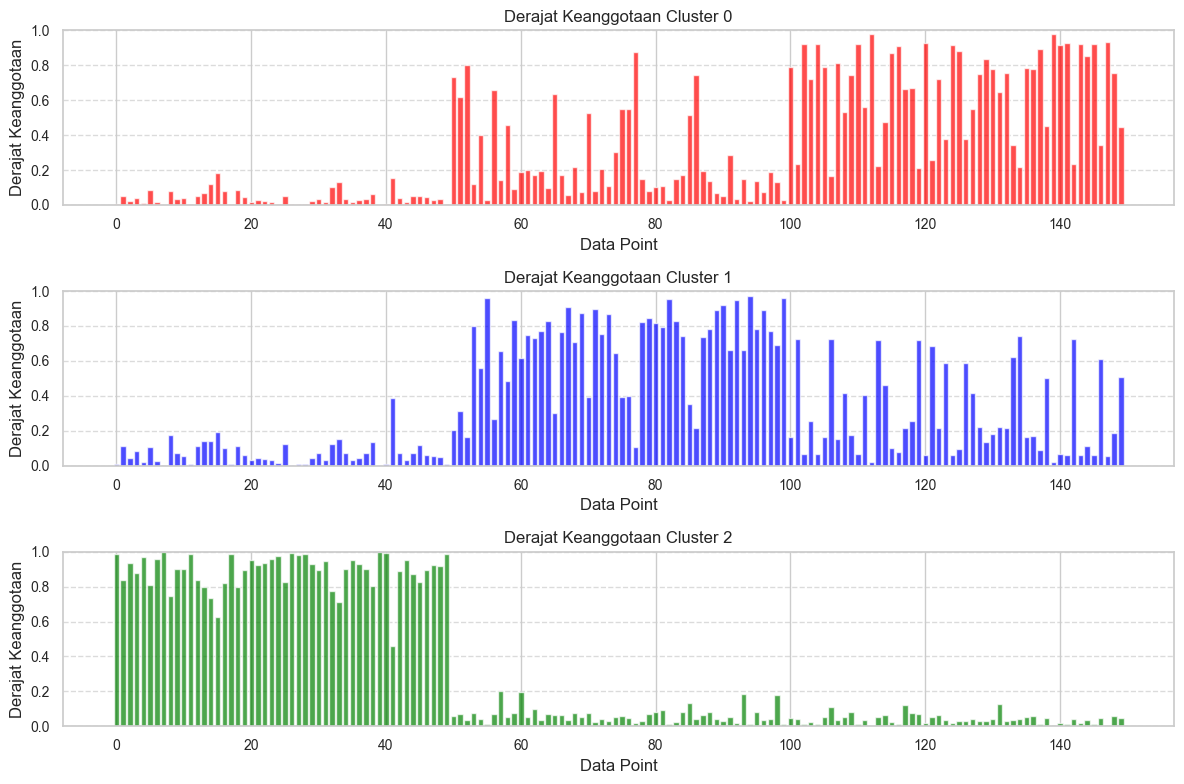

In [1224]:
# Define a list of colors for the clusters
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 8))

for i in range(n_clusters):
    plt.subplot(3, 1, i+1)
    plt.bar(range(len(U[i])), U[i], color=colors[i], alpha=0.7)
    plt.title(f'Derajat Keanggotaan Cluster {i}')
    plt.xlabel('Data Point')
    plt.ylabel('Derajat Keanggotaan')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("data/tugas6/assets/derajat_keanggotaan.png", dpi=300)
plt.show()

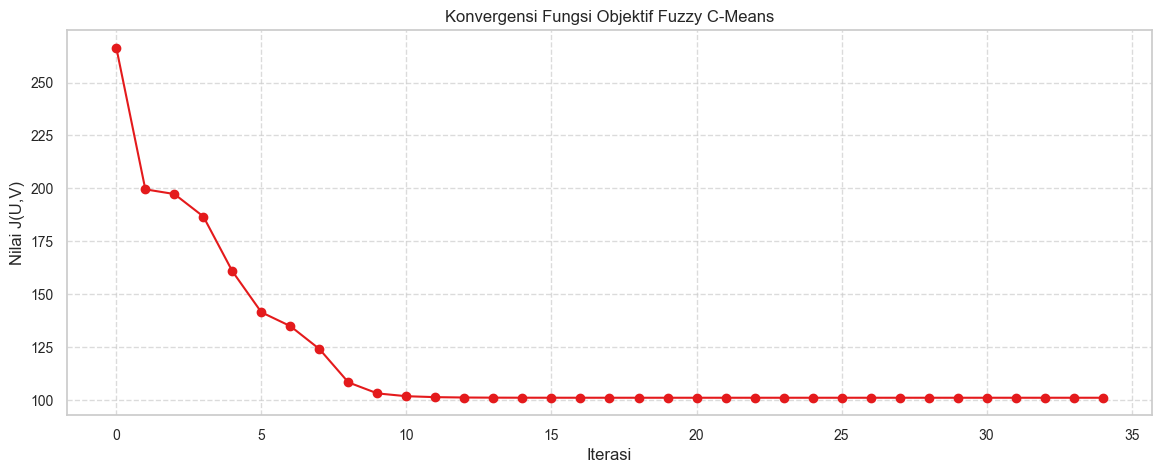

In [1225]:
plt.figure(figsize=(14, 5))
plt.plot(jm, 'o-')
plt.title('Konvergensi Fungsi Objektif Fuzzy C-Means')
plt.xlabel('Iterasi')
plt.ylabel('Nilai J(U,V)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("data/tugas6/assets/fungsi_objektif_FCM.png", dpi=300)
plt.show()